In [1]:
# TEMP: Import lagom
# Not useful once lagom is installed
import sys
sys.path.append('/home/zuo/Documents/lagom/')

from time import time

from experiment import Experiment
from algo import GoalSelection
from lagom.core.utils import Logger

logger = Logger(name='goal_selection')
algo = GoalSelection(name='goal_selection')
experiment = Experiment(logger)

experiment.add_algo(algo)

start_time = time()
experiment.benchmark(num_process=1)
print(f'\nTotal time: {time() - start_time:.2f} s')

# Save loggings
logger.save()

##################################################
# ID: 0
# seed: 0
# hidden_sizes: [16]
# hidden_nonlinearity: <function relu at 0x7ff613f1c6a8>
# lr: 0.01
# gamma: 0.99
# T: 30
# use_optimal_T: True
# predict_value: False
# standardize_r: True
# goal_sampler: <class 'goal_sampler.sw_ucb_g.SWUCBgGoalSampler'>
# num_goal: 4
# train_iter: 2
# eval_iter: 1
# train_num_epi: 30
# eval_num_epi: 100
# log_interval: 1
##################################################

Sampled Goal (1/4): [6, 2]
A* optimal steps: 1
('Train Iteration', 1):
	Total loss: 0.24578095972537994
	Num Episodes: 30
	Average Return: 0.3333333333333333
	Average Discounted Return: 0.3333333333333333
	Std Return: 0.4714045207910317
	Min Return: 0
	Max Return: 1
('Train Iteration', 2):
	Total loss: 0.36471688747406006
	Num Episodes: 30
	Average Return: 0.6333333333333333
	Average Discounted Return: 0.6333333333333333
	Std Return: 0.4818944098266986
	Min Return: 0
	Max Return: 1
########### 0.4666666666666667, 0.8
A* optima

In [2]:
logger.logs

OrderedDict([('goal_selection',
              {('ID',
                0): OrderedDict([(('Sampled goal', 0, (6, 2)),
                             OrderedDict([(('Train Iteration', 1),
                                           OrderedDict([('Total loss',
                                                         0.24578095972537994),
                                                        ('Num Episodes', 30),
                                                        ('Average Return',
                                                         0.3333333333333333),
                                                        ('Average Discounted Return',
                                                         0.3333333333333333),
                                                        ('Std Return',
                                                         0.4714045207910317),
                                                        ('Min Return', 0),
                                               

In [18]:
experiment.env.get_source_env().maze

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 0., 0., 1.],
       [1., 1., 1., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

In [46]:
from collections import deque
import numpy as np

a = deque([], maxlen=4)
a.append(1)
a.append(2)
a.append(3)
a.append(4)
#a.append(5)
np.mean(a)

2.5

In [197]:
g = SWUCBgGoalSampler(None, None)
[print(g.sample()) for _ in range(3)]

[6, 2]
[2, 5]
[1, 1]


[None, None, None]

In [227]:
a = deque([], maxlen=3)
[a.append(i) for i in range(3)]
a.append(3)
len(a) == a.maxlen

True

In [ ]:
import numpy as np

from collections import deque
from collections import OrderedDict

from .base import BaseGoalSampler
from ..utils import get_optimal_steps

from lagom.runner import Runner


class SWUCBgGoalSampler(BaseGoalSampler):
    def __init__(self, runner, config):
        super().__init__(runner, config)
        
        # Counter for iterations
        self.t = 0
        
        # Sliding window
        self.h = 5
        
        # Partition of the goal space into groups
        self.groups = self._partition_goal_space()
        self.num_groups = len(self.groups)
        
        # Sliding-window queue of selected information
        self.queue = deque([], maxlen=self.h)  # queue with size as sliding window
        
        # Initialize goal value estimate
        self.infos = OrderedDict()
        for i, group in enumerate(self.groups):  # iterate over groups of goals
            d = OrderedDict()
            for goal in group:  # iterate over goals
                d[('Goal', tuple(goal))] = {'N': 0, 'Q': deque([], maxlen=self.h)}
            # Add to dictionary
            self.infos[('Group', i)] = d
            
        # hyperparams from SWUCB-g paper
        self.D1 = 0.1
        self.D2 = 2
        self.gamma1 = 2
        self.gamma2 = 0.5
        self.alphas = [len(group)+5 for group in self.groups]
            
    def _partition_goal_space(self):
        area1 = [[5, 1], [5, 2], [5, 3],
                 [6, 1], [6, 2], [6, 3]]
        area2 = [[1, 4], [1, 5], 
                 [2, 4], [2, 5], 
                 [3, 4], [3, 5],
                 [4, 4], [4, 5],
                 [5, 4], [5, 5],
                 [6, 4], [6, 5]]
        area3 = [[1, 1], [1, 2], [1, 3], 
                 [2, 1], [2, 2], [2, 3]]
        
        return [area1, area2, area3]
        
    def sample(self):
        # Group selection
        group_id = self._group_selection()
        # Goal selection
        goal = self._goal_selection(group_id)
        
        # Record sampled group and sampled goal for update()
        self.sampled_group_id = group_id
        self.sampled_goal = tuple(goal)
        
        # Increment the counter
        self.t += 1
        
        return list(goal)
    
    def update(self, reward):
        """
        Update the dictionary of reward information of the group and the goal
        
        Args:
            reward (float): reward to the bandit
        """
        # Update the sliding-window queue of selected information
        if len(self.queue) == self.queue.maxlen:
            pop_item = self.queue.popleft()
            # Update dictionary
            info = self.infos[('Group', pop_item['Group'])][('Goal', tuple(pop_item['Goal']))]
            info['N'] -= 1
            R = info['Q'].popleft()
            assert R == pop_item['R']  # check if the correct value to be poped out
        
        # Record new information to the queue
        self.queue.append({'Group': self.sampled_group_id, 'Goal': self.sampled_goal, 'R': reward})
        # Update dictionary
        info = self.infos[('Group', self.sampled_group_id)][('Goal', tuple(self.sampled_goal))]
        info['N'] += 1
        info['Q'].append(reward)
        
        # Clean the recorded sampled group id and goal
        self.sampled_group_id = None
        self.sampled_goal = None
    
    def _group_selection(self):
        """
        Group selection
        
        Returns:
            group_id (int): the index of the selected group
        """
        if self.t < self.num_groups:  # initially linearly choose the group
            group_id = self.t
        else:
            # TODO: two ways, either max of max Q, or max of average Q within the group
            value_groups = []
            for i in range(self.num_groups):
                goal, Q = self._max_goal(i)
                uncertainty = self._uncertainty(i, original=True)
                value_groups.append(Q + uncertainty)
                
            group_id = np.argmax(value_groups)
        
        return group_id
    
    def _goal_selection(self, group_id):
        """
        Goal selection within the group
        
        Args:
            group_id (int): the index of the selected group
            
        Returns:
            goal (tuple): selected goal
        """
        if self.t < self.num_groups:  # initially uniformly sample the goal within the group
            goals = self.groups[group_id]
            idx = np.random.choice(range(len(goals)))
            goal = goals[idx]
        else:
            goal, Q = self._max_goal(group_id)
        
        return goal
    
    def _max_goal(self, group_id):
        """
        Returns the goal with max Q within the group
        
        Args:
            group_id (int): ID of the group
            
        Returns:
            goal (tuple or list): goal with max Q
            Q (float): the Q associated with the goal
        """
        info = self.infos[('Group', group_id)]
        goals = []
        Qs = []
        for g, g_info in info.items():
            goals.append(g[1])
            if len(g_info['Q']) == 0:  # empty
                Q_value = 0
            else:
                Q_value = np.mean(g_info['Q'])
            Qs.append(Q_value)
            
        idx = np.argmax(Qs)
        goal = goals[idx]
        Q = Qs[idx]
        
        return goal, Q
    
    def _uncertainty(self, group_id, original=True):
        """
        Calculate uncertainty term
        
        Args:
            group_id (int): ID of the group
            original (bool): If True, then use the original paper setting
            
        Returns:
            uncertainty (float): uncertainty term of the given group
        """
        if original:
            c = self.D2*(self.D1)**(-self.gamma2/self.gamma1)
            exponent = self.gamma2/(2*self.gamma1)
            alpha = self.alphas[group_id]
            ln = np.log(np.min([self.t, self.h]))
            N = np.sum([info['N'] for info in self.infos[('Group', group_id)].values()])
            
            uncertainty = c*(alpha*(ln/N))**exponent
        else:
            raise NotImplementedError
            
        return uncertainty
    
    def _calculate_reward(self, agent_old, agent_new, env, config, goal):
        """
        Calculate the learning progress signal as reward
        
        Args:
            agent_old (Agent): deepcopy of agent before training
            agent_new (Agent): agent after training
            env (Env): environment
            config (Config): configurations
            goal (list or tuple): trained goal
            
        Returns:
            reward (float): learning progress reward signal
        """
        # Ensure the sampled goal is consistent 
        assert tuple(self.sampled_goal) == tuple(goal)
        
        # Set goal in the environment
        env.get_source_env().goal_states = [goal]
        
        # Set max time steps as optimal trajectories (consistent with A* solution)
        if config['use_optimal_T']:
            T = get_optimal_steps(env)
        else:
            T = config['T']
            
        num_epi = 10
        
        # Create runners
        runner_old = Runner(agent_old, env, config['gamma'])
        runner_new = Runner(agent_new, env, config['gamma'])
        
        # Calculate value estimate
        D_old = runner_old.run(T, num_epi)
        D_new = runner_new.run(T, num_epi)
        r_old = np.mean([np.sum(d['rewards']) for d in D_old])
        r_new = np.mean([np.sum(d['rewards']) for d in D_new])
        
        reward = r_new - r_old
        
        return reward

In [ ]:
         

# Evaluate
# Collect one batch of data from runner
batch_data = self.runner.run(self.config['T'], self.config['eval_num_epi'])

# Useful metrics
batch_returns = [np.sum(data['rewards']) for data in batch_data]

In [279]:
from copy import deepcopy

class A(object):
    def __init__(self, val):
        self.val = val
        
a1 = A(2)

old = deepcopy(a1)

a1.val += 3

print(a1.val)
print(old.val)

a1.val is old.val

5
2


False

In [281]:
a = SWUCBgGoalSampler(None, None)
isinstance(a, SWUCBgGoalSampler)

True

# Plot curves

/home/zuo/anaconda3/envs/RL/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/zuo/anaconda3/envs/RL/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zuo/anaconda3/envs/RL/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/zuo/anaconda3/envs/RL/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/zuo/anaconda3/envs/RL/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: tuple index out of range

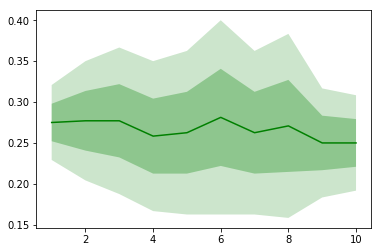

In [13]:
import numpy as np

from lagom.core.plotter import Plotter

from goal_sampler import UniformGoalSampler
from goal_sampler import RejectionGoalSampler
from goal_sampler import RejectionAstarGoalSampler
from goal_sampler import RejectionL2GoalSampler


def get_data(IDs, logs):
    data = []
    for ID in IDs:
        d = [i['Eval']['Mean success rate'] for i in logs[('ID', ID)].values()]
        data.append(d)
        
    return data

def plotting(log_file):
    # Create a plotter
    plotter = Plotter()
    
    # Get the logging dictionary of goal selection
    logs = np.load('logs/goal_selection.npy').item()['goal_selection']
    
    # Get IDs for different goal samplers, each with many random seeds
    IDs_uniform = [logs['ID'] for logs in experiment.list_configs if logs['goal_sampler'] is UniformGoalSampler]
    IDs_rejection = [logs['ID'] for logs in experiment.list_configs if logs['goal_sampler'] is RejectionGoalSampler]
    IDs_rejection_astar = [logs['ID'] for logs in experiment.list_configs if logs['goal_sampler'] is RejectionAstarGoalSampler]
    IDs_rejection_l2 = [logs['ID'] for logs in experiment.list_configs if logs['goal_sampler'] is RejectionL2GoalSampler]
       
    # Get metrics according to IDs
    cover_uniform = get_data(IDs_uniform, logs)
    cover_rejection = get_data(IDs_rejection, logs)
    cover_rejection_astar = get_data(IDs_rejection_astar, logs)
    cover_rejection_l2 = get_data(IDs_rejection_l2, logs)

    # Add curves for each goal sampler
    plotter.add_curve(cover_uniform, 
                      color='green', 
                      label='Uniform sampling', 
                      uncertainty=True,
                      scales=[0.5, 1.0],  # stds
                      alphas=[0.3, 0.2])  # transparency
    
    

    title = 'Goal selection strategies in U-maze with REINFORCE'
    xlabel = 'Goal iterations'
    ylabel = 'Maze coverage (Optimal)'
    xlim = [1, len(cover_uniform[0])]
    ylim = [0, 1 + 0.05]
    fig = plotter.plot(title, 
                       xlabel, 
                       ylabel, 
                       xlim=xlim, 
                       ylim=ylim, 
                       log_x=False, 
                       integer_x=True)

    return fig


fig = plotting('logs/goal_selection.npy')
fig.savefig('logs/tmp.png')

fig

# Animation of heatmaps (success coverage)

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle

from lagom.core.plotter import Plotter

from IPython.display import HTML


fig, ax = plt.subplots(1, 1)

plotter = Plotter()

path = 'logs/ID_0_eval_uniform.npy'
info = 'Average Return over all goals'

goals = [goal for iter_num, goal in np.load(path).item()[info].keys()]
anim_data = list(np.load(path).item()[info].values())
num_data = len(anim_data)

map_size = 4

def animate(i):
    fig.clear()
    
    data = np.array(anim_data[i]).reshape([map_size, map_size])

    ax = plotter.heatmap(data, 
                         vmin=0, 
                         vmax=1, 
                         cmap='YlGnBu', 
                         annot=True, 
                         linewidths=.0, 
                         square=True, 
                         xticklabels=np.arange(1, map_size+1), 
                         yticklabels=np.arange(1, map_size+1))
    
    ax.set_title('Training iteration: {},  goal: {}'.format(i, goals[i]))
    
    ax.add_patch(Rectangle(np.array(goals[i][::-1])-1, 1, 1, fill=False, edgecolor='yellow'))

anim = animation.FuncAnimation(fig, animate, frames=num_data, interval=2000)

anim.save('tmp.gif', writer='imagemagick', fps=.5)

HTML(anim.to_html5_video())